In [1]:
%load_ext autoreload
%autoreload 2
# pull in new changes to python modules without having to restart notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control

from jsbsim_utils import Logger, trim, simulate, linearize, rootlocus, clean_tf

Nonlinear-dynamics of aircraft

$$\dot{x} = f(x, u) \approx f(x_0, u_0) + A(x-x0) + B(u - u0)$$

Find equilibrium:

Minimize $\dot{x}$, or a subset for your problem, by changeing $x_0$, $u_0$

$$0 = f(x_0, u_0)$$

This is an optimization problem.

* Matlab: fmincon, fminsearch
* Python: scipy.minimize (Nelder-Mead, SLSQP)

Can simplify this problem with mixing matrices, to decouple the dynamcis into SISO (single-input-single output) systems.

Due to Taylor series error on the order of (dx^2). We know the linear model approx, does well near the equilibrium point. 

$\dot{\vec{x}} = \vec{f}(x, u) = A \vec{x} + B \vec{u}$

$\dot{\vec{y}} = C \vec{x} + D \vec{u}$


$A = \dfrac{\delta \vec{f}(x0, u0)}{\delta \vec{x}}$

$B = \dfrac{\delta \vec{f}(x0, u0)}{\delta \vec{u}}$

$C = \dfrac{\delta \vec{y}(x0, u0)}{\delta \vec{x}}$

$D = \dfrac{\delta \vec{y}(x0, u0)}{\delta \vec{u}}$

## Relative Stability

* Measure of relative stability. Phase margin of 90 degrees.


* sin(2*pi*f*t), where f = 10 Hz, what does a phase of 90 degrees mean -> 0.025 delay in your feedback will destabilize your system

* gain margin of 2 on pitch control -> if elevator genertes twice your predicted force, you destabilize your aircraft

# Ground Trim

In [2]:
op_ground, fdm = trim(
    aircraft='F-35B-2',
    ic={
        'ic/vt-fps': 0,
        'gear/gear-cmd-norm': 1,
        'propulsion/engine/pitch-angle-rad': np.deg2rad(0),
        'fcs/throttle-cmd-norm': 0,
        'fcs/aileron-cmd-norm': 0,
        'fcs/elevator-cmd-norm': 0,
        'fcs/rudder-cmd-norm': 0,
        'fcs/spoiler-pos-norm': 0,
        'fcs/left-brake-cmd-norm': 1,
        'fcs/right-brake-cmd-norm': 1,
        'fcs/center-brake-cmd-norm': 1,
    },
    design_vector=['ic/theta-rad', 'ic/h-agl-ft'],
    x0=[0, 0],
    verbose=True,
    method='Nelder-Mead', # works better with ground interaction
    tol=1e-12,
)
op_ground

 final_simplex: (array([[4.85765918e-04, 3.70162834e+00],
       [4.85765918e-04, 3.70162834e+00],
       [4.85765918e-04, 3.70162834e+00]]), array([9.03386380e-12, 9.03386381e-12, 9.03386381e-12]))
           fun: 9.033863801684596e-12
       message: 'Optimization terminated successfully.'
          nfev: 300
           nit: 152
        status: 0
       success: True
             x: array([4.85765918e-04, 3.70162834e+00])


{'ic/vt-fps': 0,
 'gear/gear-cmd-norm': 1,
 'propulsion/engine/pitch-angle-rad': 0.0,
 'fcs/throttle-cmd-norm': 0,
 'fcs/aileron-cmd-norm': 0,
 'fcs/elevator-cmd-norm': 0,
 'fcs/rudder-cmd-norm': 0,
 'fcs/spoiler-pos-norm': 0,
 'fcs/left-brake-cmd-norm': 1,
 'fcs/right-brake-cmd-norm': 1,
 'fcs/center-brake-cmd-norm': 1,
 'ic/theta-rad': 0.0004857659179286267,
 'ic/h-agl-ft': 3.7016283364266105}

In [3]:
op_ground['fcs/mixture-pos-norm[1]'] = 1
log_ground = simulate(
    aircraft='F-35B-2',
    op_0=op_ground,
    tf=5,
    realtime=True)

# Hover Trim

In [4]:
v_fwd = 0
hdg = 280
op_hover, fdm = trim(
    aircraft='F-35B-2',
    ic={
        'ic/h-agl-ft': 20,
        'ic/vd-fps': 0,
        'ic/vn-fps': v_fwd*np.cos(np.deg2rad(hdg)),
        'ic/ve-fps': v_fwd*np.sin(np.deg2rad(hdg)),
        'ic/theta-rad': 0,
        'gear/gear-cmd-norm': 1,
        'fcs/left-brake-cmd-norm': 0,
        'fcs/right-brake-cmd-norm': 0,
        'fcs/center-brake-cmd-norm': 0,
    },
    design_vector=[
        'fcs/throttle-cmd-norm',
        'fcs/elevator-cmd-norm',
        'propulsion/engine/pitch-angle-rad',
    ],
    x0=[0.1, 0, np.deg2rad(90)],
    verbose=True,
    bounds=[[0, 2], [-2, 2], [np.deg2rad(0), np.deg2rad(120)]],
    tol=1e-12
)
op_hover

      fun: 8.36400884630375e-12
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.76591767e-06,  1.26777593e-06, -5.10631011e-07])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 136
      nit: 16
     njev: 34
   status: 0
  success: True
        x: array([0.92512877, 1.29903228, 1.57079635])


{'ic/h-agl-ft': 20,
 'ic/vd-fps': 0,
 'ic/vn-fps': 0.0,
 'ic/ve-fps': -0.0,
 'ic/theta-rad': 0,
 'gear/gear-cmd-norm': 1,
 'fcs/left-brake-cmd-norm': 0,
 'fcs/right-brake-cmd-norm': 0,
 'fcs/center-brake-cmd-norm': 0,
 'fcs/throttle-cmd-norm': 0.9251287679467598,
 'fcs/elevator-cmd-norm': 1.2990322782500243,
 'propulsion/engine/pitch-angle-rad': 1.5707963489731316}

In [5]:
log_hover = simulate(
    aircraft='F-35B-2',
    op_0=op_hover,
    tf=20,
    realtime=False)

In [6]:
op_hover_auto = dict(op_hover)
op_hover_auto['ap/roll_hold'] = 1
op_hover_auto['ap/pitch_hold'] = 1
op_hover_auto['ap/yaw_hold'] = 1
op_hover_auto['ap/alt_hold'] = 1
op_hover_auto['ap/h-agl-cmd'] = 20

log_hover_auto = simulate(
    aircraft='F-35B-2',
    op_0=op_hover_auto,
    tf=20,
    realtime=False)

## Cruise Trim

In [7]:
def cost_cruise(fdm):
    # modify cost to also penalize throttle
    delta = fdm['propulsion/engine/pitch-angle-rad']
    theta = fdm['attitude/theta-rad']
    drag = fdm['forces/fwx-aero-lbs']
    lift = fdm['forces/fwz-aero-lbs']
    alpha = fdm['aero/alpha-rad']
    throttle = fdm['fcs/throttle-cmd-norm']
    
    udot = fdm['accelerations/udot-ft_sec2']
    vdot = fdm['accelerations/vdot-ft_sec2']
    wdot = fdm['accelerations/wdot-ft_sec2']
    pdot = fdm['accelerations/pdot-rad_sec2']
    qdot = fdm['accelerations/qdot-rad_sec2']
    rdot = fdm['accelerations/rdot-rad_sec2']
    return udot**2 + vdot**2 + wdot**2 + pdot**2 + qdot**2 + rdot**2 - 1e-3*theta**2 + 1e-3*(theta < 0)
        
op_cruise, fdm = trim(
    aircraft='F-35B-2',
    ic={
        'ic/gamma-rad': 0,
        'ic/vt-fps': 600,
        'ic/h-agl-ft': 40000,
        'gear/gear-cmd-norm': 0,
        'fcs/left-brake-cmd-norm': 0,
        'fcs/right-brake-cmd-norm': 0,
        'fcs/center-brake-cmd-norm': 0,
        'propulsion/engine/pitch-angle-rad': 0,
    },
    design_vector=[
        'fcs/throttle-cmd-norm',
        'fcs/elevator-cmd-norm',
        'fcs/rudder-cmd-norm',
        'fcs/aileron-cmd-norm',
        'ic/alpha-rad',
        'ic/beta-rad',
    ],
    cost=cost_cruise,
    x0=[0.1, 0, 0, 0, 0, 0],
    verbose=True,
    bounds=[[0, 2], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1]],
    tol=1e-12
)
op_cruise

      fun: 0.0005297457156499189
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.21823729e-07,  4.60016140e-06,  7.37257478e-10,  4.15852248e-06,
       -3.32204316e-05, -6.81889441e-06])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 371
      nit: 38
     njev: 53
   status: 0
  success: True
        x: array([ 9.21904068e-01,  1.21331841e-02,  2.13814954e-01, -8.62246625e-04,
        1.32529628e-01,  1.35273926e-03])


{'ic/gamma-rad': 0,
 'ic/vt-fps': 600,
 'ic/h-agl-ft': 40000,
 'gear/gear-cmd-norm': 0,
 'fcs/left-brake-cmd-norm': 0,
 'fcs/right-brake-cmd-norm': 0,
 'fcs/center-brake-cmd-norm': 0,
 'propulsion/engine/pitch-angle-rad': 0,
 'fcs/throttle-cmd-norm': 0.92190406838435,
 'fcs/elevator-cmd-norm': 0.012133184103038732,
 'fcs/rudder-cmd-norm': 0.21381495357328575,
 'fcs/aileron-cmd-norm': -0.0008622466249655816,
 'ic/alpha-rad': 0.132529627625931,
 'ic/beta-rad': 0.0013527392590478675}

In [8]:
op_cruise['ap/roll_hold'] = 0
op_cruise['ap/pitch_hold'] = 0
op_cruise['ap/alt_hold'] = 0
op_cruise['ap/h-agl-cmd'] = 40000

log_cruise = simulate(
    aircraft='F-35B-2',
    op_0=op_cruise,
    tf=40,
    realtime=False)

In [9]:
op_cruise_auto = dict(op_cruise)
op_cruise_auto['ic/theta-deg'] = 0
op_cruise_auto['ic/phi-deg'] = 0
op_cruise_auto['ap/roll_hold'] = 1
op_cruise_auto['ap/pitch_hold'] = 1
op_cruise_auto['ap/yaw_hold'] = 0
op_cruise_auto['ap/alt_hold'] = 0
#op_cruise_auto['ap/h-agl-cmd'] = 0

log_cruise_auto = simulate(
    aircraft='F-35B-2',
    op_0=op_cruise_auto,
    tf=20,
    realtime=False)

# Hover Control

## Pitch

In [10]:
sys = control.ss(*linearize(
    aircraft='F-35B-2',
    states=['ic/q-rad_sec'],
    states_deriv = ['accelerations/qdot-rad_sec2'],
    inputs=['fcs/elevator-cmd-norm'],
    outputs=['ic/q-rad_sec'],
    ic=op_hover,
    dx=1e-3,
    n_round=3
))
s = control.tf([1, 0], [1])
G_elev_to_pitch = -clean_tf(control.minreal(control.ss2tf(sys), 1e-3))/s
G_elev_to_pitch

0 states have been removed from the model


TransferFunction(array([-3.229]), array([1., 0., 0.]))

(inf, inf, nan, nan)

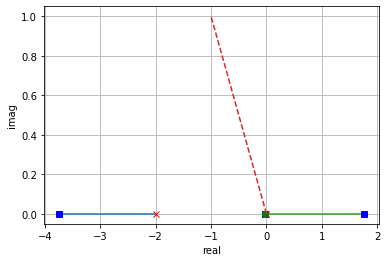

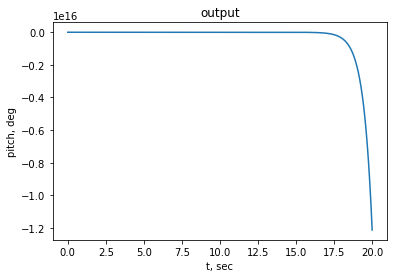

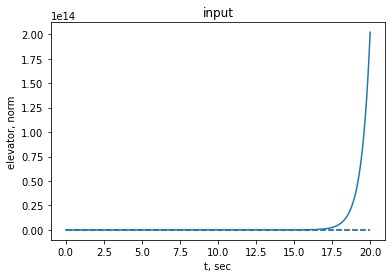

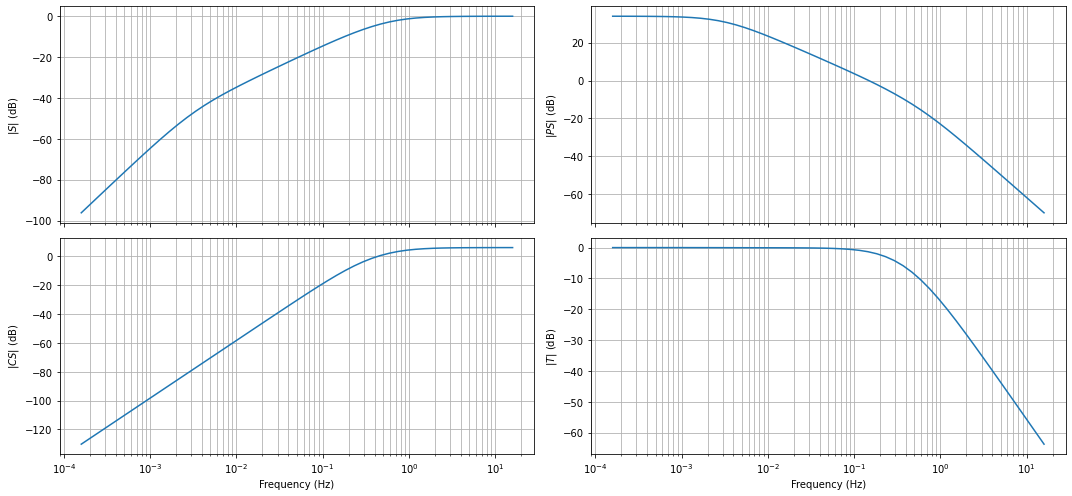

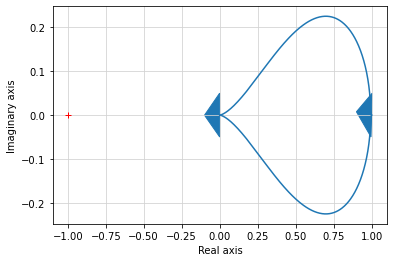

In [11]:
H_elev_to_pitch = 2*(0.01 + 1*s/(s+2))

plt.figure()
rootlocus(G_elev_to_pitch*H_elev_to_pitch)
plt.plot([0, -1], [0, 1], '--')

Gc_elev_to_pitch = G_elev_to_pitch*H_elev_to_pitch/(1 + G_elev_to_pitch*H_elev_to_pitch)

plt.figure()
step_size = 10
t, y = control.step_response(step_size*Gc_elev_to_pitch, T=np.linspace(0, 20, 1000));
plt.plot(t, y)
plt.ylabel('pitch, deg')
plt.xlabel('t, sec')
plt.title('output')

plt.figure()
# actual error was computed in radians, so, converting back here
e = np.deg2rad(step_size-y)
t, u, _= control.forced_response(H_elev_to_pitch, T=t, U=e)
plt.plot(t, u)
plt.hlines([-1, 1], t[0], t[-1], linestyles='dashed')
plt.title('input')
plt.ylabel('elevator, norm')
plt.xlabel('t, sec')

plt.figure(figsize=(15, 7))
control.gangof4(G_elev_to_pitch, H_elev_to_pitch, Hz=True, dB=True)

plt.figure()
control.nyquist(Gc_elev_to_pitch, omega=np.logspace(-3, 3, 1000));

control.margin(Gc_elev_to_pitch)

In [12]:
#20*np.log10(x) = -5
10**(-0.25)

0.5623413251903491

## Roll

In [13]:
sys = control.ss(*linearize(
    aircraft='F-35B-2',
    states=['ic/p-rad_sec'],
    states_deriv = ['accelerations/pdot-rad_sec2'],
    inputs=['fcs/aileron-cmd-norm'],
    outputs=['ic/p-rad_sec'],
    ic=op_hover,
    dx=1e-3,
    n_round=3
))
s = control.tf([1, 0], [1])
G_aileron_to_roll = -clean_tf(control.minreal(control.ss2tf(sys), 1e-3))/s
G_aileron_to_roll

0 states have been removed from the model


TransferFunction(array([-0.111]), array([1., 0., 0.]))

(inf, inf, nan, nan)

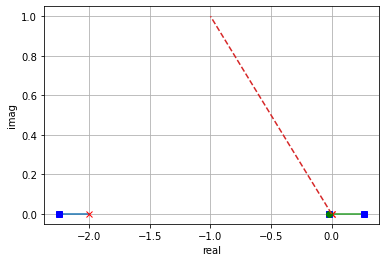

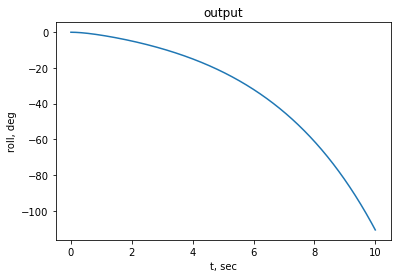

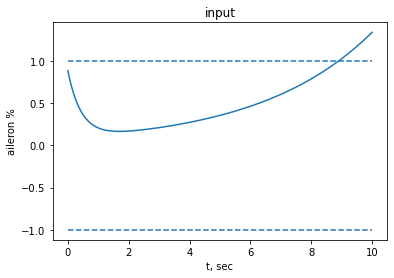

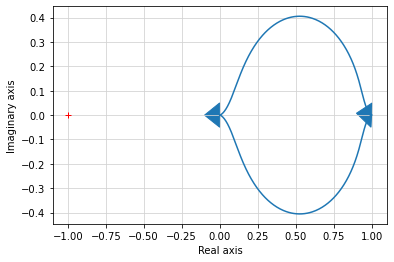

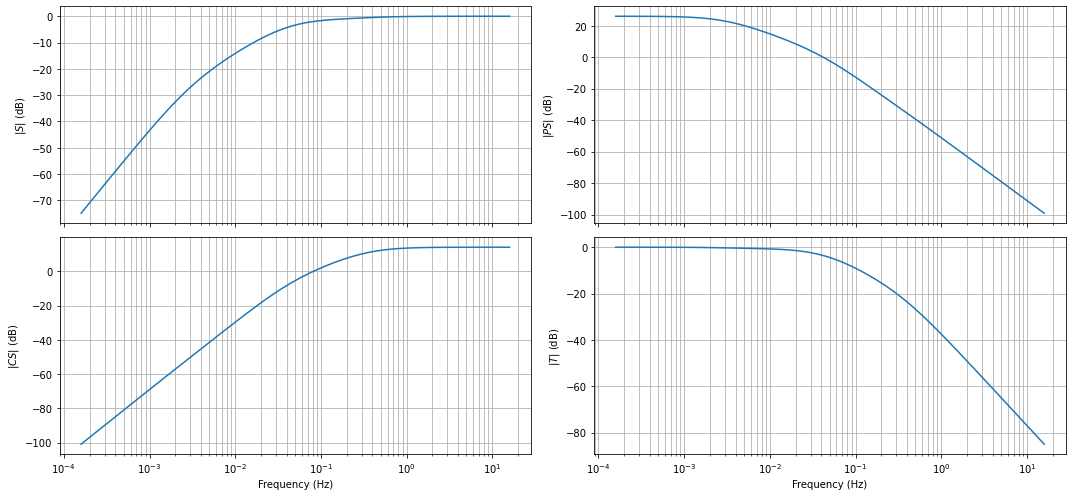

In [14]:
H_aileron_to_roll = 5*(0.01 + 1*s/(s+2))

plt.figure()
rootlocus(G_aileron_to_roll*H_aileron_to_roll)
plt.plot([0, -1], [0, 1], '--')

Gc_aileron_to_roll  = G_aileron_to_roll*H_aileron_to_roll/(1 + G_aileron_to_roll*H_aileron_to_roll)


plt.figure()
step_size = 10
t, y = control.step_response(step_size*Gc_aileron_to_roll, T=np.linspace(0, 10, 1000));
plt.plot(t, y)
plt.xlabel('t, sec')
plt.ylabel('roll, deg')
plt.title('output')

plt.figure()
# actual error was computed in radians, so, converting back here
e = np.deg2rad(step_size-y)
t, u, _= control.forced_response(H_aileron_to_roll, T=t, U=e)
plt.hlines([-1, 1], t[0], t[-1], linestyles='dashed')
plt.plot(t, u)
plt.xlabel('t, sec')
plt.ylabel('aileron %')
plt.title('input')

plt.figure()
control.nyquist(Gc_aileron_to_roll, omega=np.logspace(-3, 3, 1000));

plt.figure(figsize=(15, 7))
control.gangof4(G_aileron_to_roll, H_aileron_to_roll, Hz=True, dB=True)

control.margin(Gc_aileron_to_roll)

## Yaw

In [15]:
sys = control.ss(*linearize(
    aircraft='F-35B-2',
    states=['ic/r-rad_sec'],
    states_deriv = ['accelerations/rdot-rad_sec2'],
    inputs=['propulsion/engine/yaw-angle-rad'],
    outputs=['ic/r-rad_sec'],
    ic=op_hover,
    dx=1e-3,
    n_round=3
))
s = control.tf([1, 0], [1])
G_rudder_to_yaw = -clean_tf(control.minreal(control.ss2tf(sys), 1e-3))/s
G_rudder_to_yaw

0 states have been removed from the model


TransferFunction(array([0.]), array([1.]))

Yaw angle seems to have no impact on r moment, need to investigate. Can add another lift-fan to model this if necessary.

## Altitude

In [16]:
sys = control.ss(*linearize(
    aircraft='F-35B-2',
    states=['ic/w-fps'],
    states_deriv = ['accelerations/wdot-ft_sec2'],
    inputs=['fcs/throttle-cmd-norm'],
    outputs=['ic/w-fps'],
    ic=op_hover,
    dx=1e-3,
    n_round=3
))
G_throttle_to_alt = -clean_tf(control.minreal(control.ss2tf(sys), 1e-3))/s
G_throttle_to_alt

0 states have been removed from the model


TransferFunction(array([42.93]), array([1., 0., 0.]))

(inf, 110.46293215422145, nan, 0.4086116049446379)

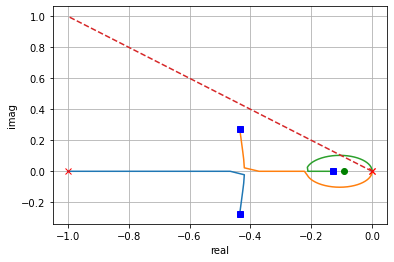

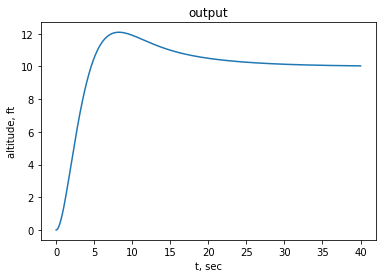

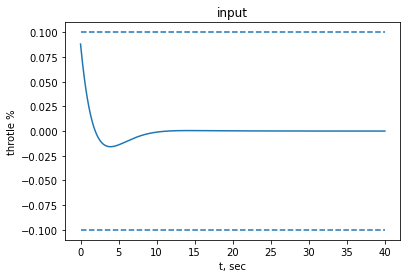

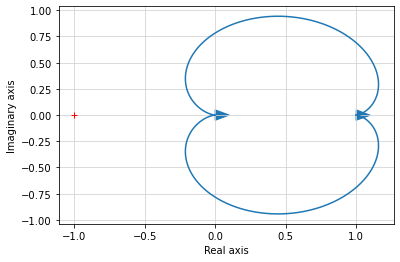

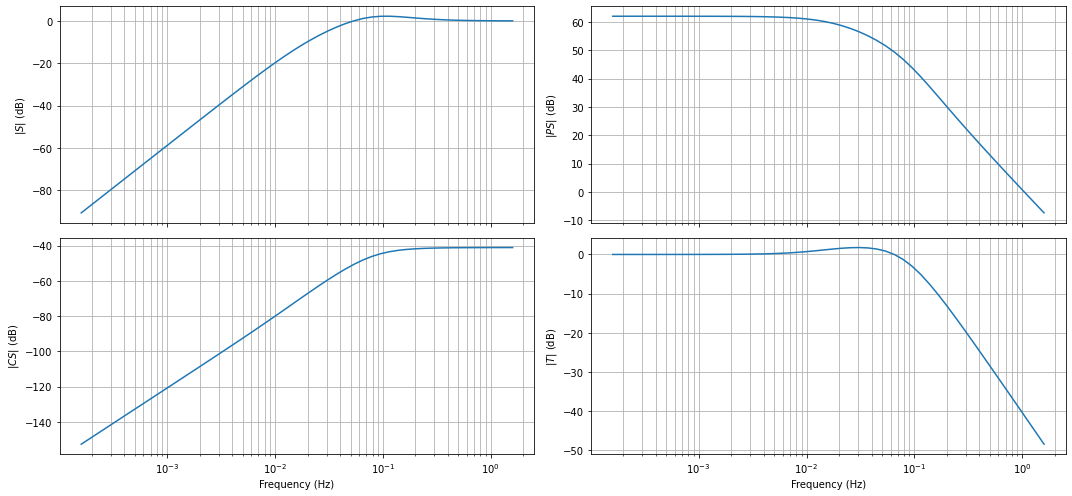

In [17]:
H_throttle_to_alt = 0.0008*(1 + s*10/(s+1))


plt.figure()
rootlocus(G_throttle_to_alt*H_throttle_to_alt)
plt.plot([0, -1], [0, 1], '--')

Gc_throttle_to_alt = G_throttle_to_alt*H_throttle_to_alt/(1 + G_throttle_to_alt*H_throttle_to_alt)

plt.figure()
step_size = 10
t, y = control.step_response(step_size*Gc_throttle_to_alt, T=np.linspace(0, 40, 1000));
plt.plot(t, y)
plt.xlabel('t, sec')
plt.ylabel('altitude, ft')
plt.title('output')

plt.figure()
# error computed in ft
e = step_size-y
t, u, _= control.forced_response(H_throttle_to_alt, T=t, U=e)
plt.hlines([-0.1, 0.1], t[0], t[-1], linestyles='dashed')
plt.plot(t, u)
plt.xlabel('t, sec')
plt.ylabel('throtle %')
plt.title('input')

plt.figure()
control.nyquist(Gc_throttle_to_alt, omega=np.logspace(-3, 3, 1000));

plt.figure(figsize=(15, 7))
control.gangof4(G_throttle_to_alt, H_throttle_to_alt, Hz=True, dB=True)

control.margin(Gc_throttle_to_alt)